In [1]:
import torch 
import cv2
import numpy as np
from model import Yolov1
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from dataset import VOCDataset
import matplotlib.patches as patches

"""
    # NOTE: I made a lot of notes on these util functons in live_feed_yolo_model.ipynb
    and also in the res repo in .coding.res/AI.res/object_detection/YOLO.res has more resources and notes
"""


'\n    # NOTE: I made a lot of notes on these util functons in live_feed_yolo_model.ipynb\n    and also in the res repo in .coding.res/AI.res/object_detection/YOLO.res has more resources and notes\n'

In [4]:
# from live_yolo import run_live_on_webcam
from model import Yolov1

In [5]:
from utils import (
    load_model
)

In [6]:
S = 7
num_boxes = 2
C = 20 # number of classes in the dataset
# List of 20 Pascal VOC classes (YOLO v1 trained on Pascal VOC dataset)
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

np.random.seed(0)
colors = np.random.uniform(0, 255, size=(len(VOC_CLASSES), 3))

DEVICE = 'mps'

In [7]:
# model = Yolov1(split_size=S, num_boxes=num_boxes, num_classes=C)
model = load_model(
    "YoloV1-train-on-entire-dataset-and-4096",
    # "YoloV1",
    # "YoloV1-TEST",
    Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE),
    DEVICE
)

In [8]:
def openImage(img_path):
    # Open image using PIL
    image = Image.open(img_path)
    # Convert image to NumPy array
    return np.array(image)

In [9]:
def image_to_tensor(img):
    '''
    Converts a numpy image array into a tensor array, that can be feed into the yolov1 model
    
    Parameters
        img (numpy.ndarray): shape (height, weight, 3)
        
    returns
        tensor(pytorch.tensor) :  shape (1, 3, 448, 448)
    
    '''
    img_pil = Image.fromarray(img)  # convert to PIL so the transforms can happen 

    #transform the image
    transform = transforms.Compose([ # Expects a PIL image
        transforms.Resize((448, 448)),
        transforms.ToTensor() # convert to tensors and NOTE: normalizes it under the hood
    ])
    image_tensor = transform(img_pil)
    # image_tensor = image_tensor.permute(2, 0, 1) # change the shape from (448, 448, 3) to (3, 448, 448)

    # to be able to send only one image at a time it needs to be in a batch so the model can process it meaning image is (3, 448, 448) to (1, 3, 448, 448) use unsqeeze(0)
    image_tensor = image_tensor.unsqueeze(0).to(DEVICE)
    return image_tensor

### Run live

In [8]:
# Generate a tensor of shape (1, 1470) with random values
test_output_tensor = torch.randn(1, 1470)
test_output_tensor.shape

torch.Size([1, 1470])

In [10]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    
    Parameters:
        predictions (tensor): of shape (1, 1470)
        s (int): split size 7, image split into 7x7 = 49 cells
    
    returns
        converted_preds (torch(1, 7, 7, 6)) : the 6 represents 
            [
                predicted_class,
                best_bounding_box_confidence,
                bbox_coordinates (X, Y, W, H)
            ] example: [10, 1.3, 0.9, 0.2, 3.6, 2.9]
        the bbox_coordinates are converted to be draw relative to entire image instead of one cell
        
    
    
    
    NOTE: that the example prints below in the comments of this function are not from an image but where auto generated matrix => predictions = torch.randn(1, 1470)
    """

    predictions = predictions.to("cpu") # moves from GPU to CPU so we can display the predictions
    batch_size = predictions.shape[0] # gets the number so of batches Since predictions originally has shape (1, 1470), batch_size will be 1. This means we are working with a single image at a time.

    predictions = predictions.reshape(batch_size, 7, 7, 30) # reshape from (1, 1470) to (1, 7, 7, 30)
    
    '''
            (1, 7, 7, 30)
                7 x 7 → The grid of the image (YOLO divides the image into 7x7=49 cells).
                30 → Each grid cell has 30 values containing:
                        Class probabilities (0-19 for 20 classes).
                        Bounding box 1 (20-24: confidence, x, y, width, height).
                        Bounding box 2 (25-29: confidence, x, y, width, height).
    '''
    
    
    #  Key Idea: Each grid cell predicts two bounding boxes, but only one will be selected later based on confidence scores.
    bboxes1 = predictions[..., 21:25] # grab the first bounding box (Pc1, X, Y, W, H) for every cell. shape of (1, 7, 7, 4), the coordinates of bounding boxes 1 in every cell
    bboxes2 = predictions[..., 26:30] # grab the second box (Pc2, X, Y, W, H) for every cell. shape of (1, 7, 7, 4), the coordinates of bounding boxes 2 in every cell

    scores = torch.cat(
        (
            # concat both the bounding boxes predictions for every cell
            predictions[..., 20].unsqueeze(0), # .unsqueeze() addes a batch
            predictions[..., 25].unsqueeze(0) # The ... (ellipsis) means "keep all dimensions except the last one" # (torch.Size([1, 7, 7, 30]) to torch.Size([1, 7, 7]))
        ), dim=0)
    '''
        scores (torch.Size(2, 1, 7, 7) : will be a matrix concated  of the confidence score of both bounding boxes for every cell  
            [ [bbox1 confidence for every cell] , [bbox2 confidence for every cell]] 1, 
            
            example print scores 
                tensor([[[  [-1.9096, -0.4176, -0.0925, -0.5932, -1.5929, -2.0741, -1.9604],
                            [-1.1711, -0.6542, -0.2692, -0.6121, -0.3355, -0.6158,  1.8577],
                            [ 1.1144, -1.6825,  1.7893,  0.2704, -0.8323,  0.2164,  1.4037],
                            [ 1.4628, -3.0601, -0.1817, -0.8548,  0.0859,  1.6410,  0.1317],
                            [ 0.2667,  0.3782, -0.1150, -0.0679,  0.6253, -1.3278,  0.0438],
                            [-1.1023,  0.4228,  0.3744, -0.4006,  0.6161, -0.3020,  0.1337],
                            [ 0.7268, -1.1073, -1.3228, -0.6765, -0.5863,  0.0440,  2.3901]]],


                            [[[-0.3961,  0.2583,  0.6119,  0.2240, -0.9047, -0.9828,  0.3041],
                            [-1.2661, -1.7880,  0.2875,  0.4656, -0.0392,  0.1624, -1.9979],
                            [ 0.5141, -1.6320, -0.5623,  2.8383,  1.1757, -0.4600,  0.0351],
                            [-0.7938,  1.2586,  1.3204,  0.2898,  0.2612,  0.7842,  0.6461],
                            [ 0.8624,  1.2636,  0.4690,  0.5509, -0.3870, -1.6138,  0.8850],
                            [-0.6498,  2.4141,  0.7039,  0.6559, -0.7215, -0.3769,  0.5266],
                            [ 0.6420,  0.0411,  0.3346, -0.3035,  0.0212, -1.1077, -2.1625]]]])

            # torch.cat(..., dim=0) stacks both tensors along dimension 0, creating a (2, 7, 7) tensor.
            # The first row contains confidence scores for bounding box 1.
            # The second row contains confidence scores for bounding box 2.
    '''
        
        
    best_box = scores.argmax(0).unsqueeze(-1)
    '''example of this print:   print(scores, scores.shape, scores.argmax(0), scores.argmax(0).shape)
                                        (tensor([[[ [-1.9096, -0.4176, -0.0925, -0.5932, -1.5929, -2.0741, -1.9604],
                                                    [-1.1711, -0.6542, -0.2692, -0.6121, -0.3355, -0.6158,  1.8577],
                                                    [ 1.1144, -1.6825,  1.7893,  0.2704, -0.8323,  0.2164,  1.4037],
                                                    [ 1.4628, -3.0601, -0.1817, -0.8548,  0.0859,  1.6410,  0.1317],
                                                    [ 0.2667,  0.3782, -0.1150, -0.0679,  0.6253, -1.3278,  0.0438],
                                                    [-1.1023,  0.4228,  0.3744, -0.4006,  0.6161, -0.3020,  0.1337],
                                                    [ 0.7268, -1.1073, -1.3228, -0.6765, -0.5863,  0.0440,  2.3901]]],
                                            
                                            
                                                    [[[-0.3961,  0.2583,  0.6119,  0.2240, -0.9047, -0.9828,  0.3041],
                                                    [-1.2661, -1.7880,  0.2875,  0.4656, -0.0392,  0.1624, -1.9979],
                                                    [ 0.5141, -1.6320, -0.5623,  2.8383,  1.1757, -0.4600,  0.0351],
                                                    [-0.7938,  1.2586,  1.3204,  0.2898,  0.2612,  0.7842,  0.6461],
                                                    [ 0.8624,  1.2636,  0.4690,  0.5509, -0.3870, -1.6138,  0.8850],
                                                    [-0.6498,  2.4141,  0.7039,  0.6559, -0.7215, -0.3769,  0.5266],
                                                    [ 0.6420,  0.0411,  0.3346, -0.3035,  0.0212, -1.1077, -2.1625]]]]),
                                        torch.Size([2, 1, 7, 7]),
                                        
                                        tensor([[[1, 1, 1, 1, 1, 1, 1],
                                                [0, 0, 1, 1, 1, 1, 0],
                                                [0, 1, 0, 1, 1, 0, 0],
                                                [0, 1, 1, 1, 1, 0, 1],
                                                [1, 1, 1, 1, 0, 0, 1],
                                                [1, 1, 1, 1, 0, 0, 1],
                                                [0, 1, 1, 1, 1, 0, 0]]]),
                                        torch.Size([1, 7, 7]))
            argmax(0) finds the index of the higher confidence score per grid cell.
            If the first box has a higher confidence, best_box will contain 0 at that cell.
            If the second box has a higher confidence, best_box will contain 1.
            best_box = .unsqueeze(-1) adds an extra dimension, shape from torch.Size([1, 7, 7]) to torch.Size([1, 7, 7, 1])), addes the 1 at the end
            
            
            print(best_box, best_box.shape)

                (tensor([[[[1], [1], [1], [1], [1], [1], [1]],
                        [[0], [0], [1], [1], [1], [1], [0]],
                        [[0], [1], [0], [1], [1], [0], [0]],
                        [[0], [1], [1], [1], [1], [0], [1]],
                        [[1], [1], [1], [1], [0], [0], [1]],
                        [[1], [1], [1], [1], [0], [0], [1]],
                        [[0], [1], [1], [1], [1], [0], [0]]]]),
                        
                torch.Size([1, 7, 7, 1]))


    '''
    
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    '''
        Explaining above line:
            If best_box = 0:
                (1 - best_box) = 1 → bboxes1 remains/ bounding box 1 has a better confindence score
            If best_box = 1:
                (1 - best_box) = 0 → bboxes2 remains.
                
        
            
            print(bboxes1)
                [[
                [ 1.8404e+00,  9.2849e-01, -6.6243e-01, -6.3148e-01], # this is a single cell with the bboxes1 predicted coordinates (X, Y, W, H)
                [ 1.3020e-02, -6.6302e-01,  7.2430e-01,  1.3816e+00], # this is a single cell with the bboxes1 predicted coordinates (X, Y, W, H)
                [-1.0413e+00, -2.3033e-01, -3.6351e-01,  3.1459e-01],
                [-1.3065e+00, -1.5369e-01, -9.1590e-01,  1.1410e+00],
                [ 1.0485e+00,  9.2511e-01,  2.1150e+00,  3.0299e-01],
                [-1.6069e+00, -1.1297e+00,  2.4561e-01,  5.6617e-01],
                [-5.7635e-01, -2.2609e-01,  1.0804e+00,  8.8514e-01]],
                    etc....
                    ]])
                
            NOTE: bboxes1 * (1 - best_box) = this is setting all the bboxes1 coordinates (X, Y, W, H) to be either = all 0's if best_box = 1 or leaving the data in bboxes1 if best_box = 0, below
            
            print(bboxes1 * (1-best_box)) # the last row of data
                [[ 1.8404e+00,  9.2849e-01, -6.6243e-01, -6.3148e-01], # this is a single cell with the bboxes1 predicted coordinates (X, Y, W, H)
                [ 0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00],
                [-0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00],
                [-0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00],
                [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
                [-1.6069e+00, -1.1297e+00,  2.4561e-01,  5.6617e-01],
                [-5.7635e-01, -2.2609e-01,  1.0804e+00,  8.8514e-01]],
                        etc....
                    ]])
            
            NOTE: now we set the zeros from above to 1 meaning bboxes2 has a better confidence score for thoses cells
            print(bboxes1 * (1 - best_box) + best_box)
                [[ 1.8404e+00,  9.2849e-01, -6.6243e-01, -6.3148e-01], # this is a single cell with the bboxes1 predicted coordinates (X, Y, W, H)
                [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
                [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
                [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
                [ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00],
                [-1.6069e+00, -1.1297e+00,  2.4561e-01,  5.6617e-01],
                [-5.7635e-01, -2.2609e-01,  1.0804e+00,  8.8514e-01]]]])
                
                

            NOTE: Now we do a matrix element-wise multiplication here best_box * bboxes2 in below print statement
                It basically concatenates the best bounding boxs from each cell, i.e lets say bboxes2 in cell 1 has a better score than bboxes1, then we will have all 1's in that bboxes1 cell (X=1, Y=1, W=1, H=1), meaning if we mulitply them we will get bboxes2 data, 1 * bboxes2 = bboxes2 
                
            print(bboxes1 * (1 - best_box) + best_box * bboxes2)
                [[ 1.8404e+00,  9.2849e-01, -6.6243e-01, -6.3148e-01],
                [ 6.6197e-01,  1.6398e+00,  1.2423e+00, -1.0251e+00],
                [-1.1054e-01,  2.0531e-01, -5.6153e-01,  1.2417e+00],
                [ 2.2253e+00,  8.2602e-03,  3.1504e-01,  2.3796e+00],
                [-8.7498e-02,  2.2774e-01, -2.5107e-01,  7.7552e-01],
                [-1.6069e+00, -1.1297e+00,  2.4561e-01,  5.6617e-01],
                [-5.7635e-01, -2.2609e-01,  1.0804e+00,  8.8514e-01]]]])

            
    '''

    # create a numpy array with ints from 0 to 6, 7(split_size), it repeats that for each grid 7x7 (SxS) and then addes a batch at the last dimension
        # torch.arange(7).repeat(batch_size=1_forOneImage, 7, 1).unsqueeze(-1)
            # tensor([[
            #     [[0], [1], [2], [3], [4], [5], [6]],
            #     [[0], [1], [2], [3], [4], [5], [6]],
            #     [[0], [1], [2], [3], [4], [5], [6]],
            #     [[0], [1], [2], [3], [4], [5], [6]],
            #     [[0], [1], [2], [3], [4], [5], [6]],
            #     [[0], [1], [2], [3], [4], [5], [6]],
            #     [[0], [1], [2], [3], [4], [5], [6]]
            #     ]])
            # torch.Size([1, 7, 7, 1])
    
    #NOTE: I believe we could save some memory and make it faster if we make cell_indices just a one dimensional array containain [[0], [1], [2], [3], [4], [5], [6]] and broadcasting it when needed instead of using repeates i.e [[[0], [1], [2], [3], [4], [5], 6]], [[0], [1], [2], [3], [4], [5], [6]], etc..]]


    '''

     NOTE: cell_indices contains the number of columns, in this example we have 7 so [[[0], [1], [2], [3], [4], [5], [6]], etc..], to get the objects midpoint relative to the entire image we use the (cell | column that its in) + the midpoint * a cells X or Y dimension, that why we permute the cell_indices to get Y, the columns for X runs the other way, so for x cell_indices =  [[[0], [1], [2], [3], [4], [5], 6]], [[0], [1], [2], [3], [4], [5], [6]], etc..]] but for y they are  [[[0],[0],[0],[0],[0],[0],[0]],[[1],[1],[1],[1],[1],[1],[1]], etc...]
    '''
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)

    ###NOTE: Converting the bounding boxes sizes to make it relative to the entire image rather than its cell
    
    '''
     Explaingin grabbing x variable below which is the X coordinate from the best bounding boxes
     
        1) 1: represents the entire image, we divide it by 7(split_size) to get the size of each cell for the 1 image
        2) best_boxes[..., :1] : grabs the X index 
        3) then we are element wise addition with cell_indices (best_boxes[..., :1] + cell_indices), cell_indices= nested array = [[[0], [1], [2], [3], [4], [5], [6]], etc..]
            bestbbox => cell_1  =>  X + 0 | bestbbox => cell_2  =>  X + 1 | bestbbox => cell_3  =>  X + 2, etc...
            bestbbox => cell_8  =>  X + 0 | bestbbox => cell_9  =>  X + 1 | bestbbox => cell_10 =>  X + 2, etc...
            bestbbox => cell_15 =>  X + 0 | bestbbox => cell_16 =>  X + 1 | bestbbox => cell_17 =>  X + 2, etc...
        4) NOTE: Then we draw that bbox out from the cell but making it relative to the entire image
            ### The X and Y are the coordinates of the objects (cat) mid-point in a CELL
            ### The W, H are going to be the width and height of that object relative to the cell, the W and H can be grater than 1, because the obect can be larger than the cell
            To explain this further
                    Suppose we have a 7×7 grid (split_size = 7) on the image.
                    Each cell covers 1/7 ≈ 0.1429 of the image width and height.
                    The objects mid-point in a cell is 0.5.
                        global_x = (cell_column + 0.5) * 1/7
                    This gives the object's true x-position relative to the image.
                    NOTE: the reason we multiply the cell_colum
            
    '''
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    
    
    ''' 
        Most of the concepts for grab the y coordinates is similiar to X, however we want to reorder the cell_indices = [[[0], [1], [2], [3], [4], [5], [6]], etc..] so we are multipling it by the Y's index instead of the X's index
        
            so cell_indices now looks like = [[0],[0],[0],[0],[0],[0],[0]
        ],
        
    '''
    
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    
    w_y = 1 / S * best_boxes[..., 2:4] # just makes the W and H relative to the size of its cell the X and Y will draw it relative to the entire image
    
    converted_bboxes = torch.cat((x, y, w_y), dim=-1) # concat the bounding boxes that have been converted to the ratio of entire image
    

    # grab the 20 class predictions: shape of [1, 7, 7, 20], .argmax(-1) returns the index (not value) of the maximum element per row of the last dimension.
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
            # here the unsqeeze(-1) addes a batch at the last dimension
                # [[[1],[7],[16],[10],[0],[4],[7]], [], [], etc..] ==>  [[1,7,16,10,0,4,7], [], etc...]
            # tensor([[
            #      [ 1,  7, 16, 10,  0,  4,  7 (class/obj is the one identitied in this cell ) ],
            #      [10,  9,  4,  9, 13,  5,  5],
            #      [17, 19, 14,  9,  3, 14,  8],
            #      [ 6,  1, 19,  6,  4,  2, 17],
            #      [13, 10,  9, 17,  8,  8, 17],
            #      [15, 17,  4, 13,  2, 13, 18],
            #      [ 0,  7, 13,  7, 14, 14,  9]]])
            


    # grab the max/most confident from the two predicted bounding boxes for every cell
    # best_confidence will be the prediction of wethat the predicted_class is in that cell, we will get a lot of best_confidence but we will dropout the ones that can pass a non_max_suppression
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(-1)
    
    converted_preds = torch.cat(
        #concate shapes
        #  (1, 7, 7, 1)  +  (1, 7, 7, 1) +  (1, 7, 7, 4)   ==> (1, 7, 7, 6)
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [17]:
def cellboxes_to_boxes(out, S=7):
    '''
    Expects an out of shape (1, 1470) the prediction of the yolo output
    
    Parameters
    ----------
        out (shape (1, 1470)) : model output
        S (int) : Split_size, how many cells we divide an image into, 7x7=49 cells    
    
    Returns
    -------
        creates a nested list predicted bounding boxes, [ [class_id, confidence_score, x1, y1, x2, y2]* for each cell in image, etc...   ]
    
    '''
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1) # reshapes the output from convert_cellboxes from (1, 7, 7, 6) to (1, 49, 6), this removes one dimension, and reorganizes the data

    converted_pred[..., 0] = converted_pred[..., 0].long() # convert the value/tensor at the first index of the last dimension from float to int, we had values of 1.6000e+01 this just converts it into 16
    
    batch_size = out.shape[0] #amount of images, if we had seven images output of yolo would be (7, 1470)
    
    all_bboxes = []
    print("I", converted_pred.shape)
    
    # NOTE: this is just taking the tensor matrix and converting it into a python list, maybe we can just do it without convert it into a basic python list, will try for other projects
    for ex_idx in range(batch_size): # this for-loop is not needed if your only working with one image
        bboxes = []

        # loop thru every predicted bounded box, each cell had one: 7x7= 49 cells
        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [ ]:
# img_tensor = image_to_tensor(openImage("./data/images/000025.jpg"))

# # for idx in range(1): 
# bboxes = cellboxes_to_boxes(model(img_tensor))\

# bboxes

I torch.Size([1, 49, 6])


### Intersection Over Union

* IoU

During Training: Used to assign predicted boxes to ground truth (i.e., the box with the highest IoU is considered responsible for the object).  


During Inference: Used in NMS to filter overlapping boxes.

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union between two bounding boxes.

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4) 
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    # Grab the X, Y, W, H 
    if box_format == "midpoint":
        # 
        box1_X = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        print("\n\nBOX 1 X from MID-POINT", box1_X,"\n\n")
        box1_Y = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_W = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_H = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        
        box2_X = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_Y = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_W = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_H = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
        
    # Grab the X, Y, W, H 
    if box_format == "corners":
        box1_X = boxes_preds[..., 0:1]
        print("\n\nBOX 2 X from CORNERS", box1_X,"\n\n")
        box1_Y = boxes_preds[..., 1:2]
        box1_W = boxes_preds[..., 2:3]
        box1_H = boxes_preds[..., 3:4]  # (N, 1)
        
        box2_X = boxes_labels[..., 0:1]
        box2_Y = boxes_labels[..., 1:2]
        box2_W = boxes_labels[..., 2:3]
        box2_H = boxes_labels[..., 3:4]
        

    # grab the coordinates with the maximum value, this combines the size of 
    X = torch.max(box1_X, box2_X)
    Y = torch.max(box1_Y, box2_Y)
    W = torch.min(box1_W, box2_W)
    H = torch.min(box1_H, box2_H)

    # .clamp(0) is for the case when they do not intersect
    intersection = (W - X).clamp(0) * (H - Y).clamp(0)
    
    box1_area = abs((box1_W - box1_X) * (box1_H - box1_Y))
    box2_area = abs((box2_W - box2_X) * (box2_H - box2_Y))
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [37]:
test_boxes_preds =  torch.rand((1, 7, 7, 6))  
test_boxes_labels =  torch.rand((1, 7, 7, 6))  
test_boxes_labels

tensor([[[[0.7687, 0.6337, 0.3214, 0.9026, 0.0506, 0.1965],
          [0.0190, 0.6242, 0.8812, 0.4789, 0.1296, 0.8938],
          [0.6187, 0.2259, 0.3819, 0.3780, 0.8221, 0.9859],
          [0.6107, 0.9831, 0.6032, 0.8312, 0.8668, 0.4675],
          [0.2714, 0.3950, 0.1430, 0.2882, 0.7110, 0.8806],
          [0.5608, 0.0342, 0.8578, 0.8941, 0.3610, 0.5189],
          [0.6674, 0.0627, 0.8274, 0.0733, 0.3330, 0.2915]],

         [[0.5421, 0.4383, 0.3486, 0.3025, 0.8182, 0.7484],
          [0.6312, 0.1816, 0.9473, 0.9867, 0.1872, 0.2836],
          [0.4914, 0.2576, 0.2854, 0.0722, 0.4375, 0.1031],
          [0.6454, 0.8523, 0.2576, 0.7448, 0.5181, 0.6860],
          [0.9982, 0.3467, 0.2058, 0.1253, 0.4932, 0.2565],
          [0.1457, 0.5848, 0.2365, 0.5000, 0.9728, 0.6532],
          [0.4582, 0.3591, 0.2245, 0.0668, 0.7217, 0.0070]],

         [[0.4263, 0.7842, 0.1312, 0.4708, 0.4111, 0.3993],
          [0.7871, 0.7557, 0.6382, 0.6259, 0.7957, 0.6659],
          [0.0543, 0.5566, 0.1504, 0

In [38]:
intersection_over_union(test_boxes_preds, test_boxes_labels, box_format="midpoint").shape




BOX 1 X from MID-POINT tensor([[[[ 0.0563],
          [-0.1063],
          [ 0.0251],
          [ 0.4477],
          [-0.2546],
          [ 0.7057],
          [ 0.7180]],

         [[-0.2649],
          [ 0.4185],
          [ 0.3257],
          [ 0.2450],
          [ 0.7391],
          [ 0.7469],
          [ 0.2724]],

         [[ 0.9515],
          [ 0.5354],
          [ 0.7635],
          [ 0.2255],
          [ 0.6037],
          [ 0.5868],
          [ 0.6825]],

         [[ 0.2201],
          [ 0.2489],
          [ 0.1974],
          [ 0.3773],
          [ 0.7155],
          [-0.0673],
          [ 0.6418]],

         [[-0.2275],
          [-0.2184],
          [ 0.3700],
          [ 0.1807],
          [ 0.4779],
          [ 0.5696],
          [ 0.7119]],

         [[ 0.3758],
          [ 0.0638],
          [-0.0537],
          [ 0.2187],
          [ 0.8541],
          [ 0.1411],
          [ 0.3145]],

         [[ 0.6531],
          [-0.2440],
          [-0.1473],
          [-0.0293

torch.Size([1, 7, 7, 1])

### Non-max Suppression

* NMS
Applied to remove redundant bounding boxes after predictions are made.

Before all predicted bounding boxes:
<img src="./ref_imgs/nms-before.png" alt="Description" width="100">

After nms to remove redundant bboxes
<img src="./ref_imgs/nms-after.png" alt="Description" width="100">


<b>What NMS is doing.</b>

0. Before we do NMS, we have a basic threshold this is not the IOU_threshold, this threshold is just to remove bboxes with a low confidence score. then do the following

1. Example: we get 3 bboxes 
<img src="./ref_imgs/during-nms.png" alt="Description" width="200">
    1. each of them have a probability score associated with that box 0.3, 0.9, 0.6, the probability is bewteen 0-1 and it indicts how likely that there is an object in that bbox.

2. We grab the highest bbox which in this case is the one with a 0.9 probability
<img src="./ref_imgs/nms-01.png" alt="Description" width="200">

3. Then we compare it with the other boxes that have a lower probability, and we calculate the IOU between them, example IOU = between 0.9 vs 0.6 bboxes = 0.51
<img src="./ref_imgs/nms-02.png" alt="Description" width="200">
    1. if the result is higher than an IOU_threshold, like 0.5 then we remove the 0.6 bbox. 

4. then we compare the 0.9 and 0.3 bboxes, example IOU result = 0.6, which is higher than out IOU_threshold, so we remove the 0.3 bbox

5. If we have multiple class predictions in the image, example: a car and a horse, then we need to do NMS for each different class separately.


In [ ]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non-Max-Suppression given bboxes, this will remove predicted boxes with a low confidence scores

    Parameters:
        bboxes (python list): list of lists containing all bboxes with each bboxes specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        bboxes_after_nms (python-list): bboxes after performing NMS given a specific IoU threshold
        
        
    NOTE:   threshold (Confidence Threshold) → Filters out low-confidence detections before applying NMS.
            iou_threshold (IoU Overlap Threshold) → Controls the suppression of overlapping boxes after filtering.
    """

    assert type(bboxes) == list # assert to python list
    
    # removes bounding boxes that are lower than the threshold confidence score
    bboxes = [box for box in bboxes if box[1] > threshold]

    #  Sort the list of bounding boxes (bboxes) in descending order based on the confidence score (x[1]) of each bounding box.
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    # remove overlapping boxes with the IOS threshold
    while bboxes:
        chosen_box = bboxes.pop(0) # Start a queue to look thru all the boxes
        bboxes = [
            box for box in bboxes
            if box[0] != chosen_box[0] # check to see if the classes are the same if the bbox classes are different than we dont want to compare them IOU is only done when comparing bboxes for the same class, example : a car and a horse bbox
            or intersection_over_union(
                torch.tensor(chosen_box[2:]), # send the coordinates of the bbox in queue  (x1, y1, x2, y2)
                torch.tensor(box[2:]), # send the coordinates of the bbox from the loop
                box_format=box_format,
            )
            < iou_threshold  # if the IOU is less than the threshold then we will keep that box
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

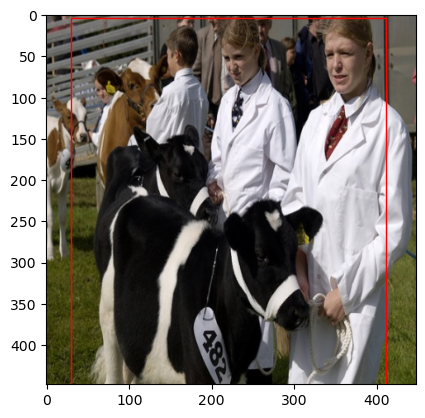

In [ ]:
img_tensor = image_to_tensor(openImage("./data/images/000025.jpg"))

# for idx in range(1): 
bboxes = cellboxes_to_boxes(model(img_tensor))
bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="corners")


# bboxes
# plot_image(img_tensor[0].permute(1, 2, 0).to(DEVICE), bboxes)

In [19]:

def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image
    
    
    
    NOTE: Moving tensors from mps (Apple’s Metal Performance Shaders) to cpu can slow down training if you're frequently transferring data back and forth. However, for visualization (like plotting images), it's necessary since NumPy and Matplotlib don’t support mps tensors.
    
    """
    
    
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()  # Ensure it’s detached before conversion
        # .detach() ensures no gradients are tracked.
        # .cpu().numpy() only happens when necessary (for plotting).
    im = np.array(image)  # Now NumPy can process it
    
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()
